<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left" height="60"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes
<br>MIT Licensed
<br>Author: Leandro Pessini

# Data Wrangling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

Dataset provided by [Moby Bikes](https://data.gov.ie/dataset/moby-bikes) through a public [API](https://data.smartdublin.ie/mobybikes-api). 


Dataset provided by [Met Éireann](https://www.met.ie/) through a public [API](https://data.gov.ie/dataset/met-eireann-weather-forecast-api/resource/5d156b15-38b8-4de9-921b-0ffc8704c88e).

<a id="1.1"></a>
## Rentals Data - Moby Bikes

### Data fields

- `HarvestTime` - Data retrieval timestamp
- `BikeID` - Unique bike ID used for rent bike
- `Battery` - Battery status (max distance in km)
- `BikeIdentifier` - Bike Identifier (Generally contains only digits, might contains chars)
- `BikeTypeName` - Bike type name
- `EBikeProfileID` - E-bike Profile ID (Every ebike profile has defined Geofence (allowed riding areas))
- `EBikeStateID` - EBike State (Indicates: {1:'Warning - is in move and not rented',2:'Normal',3:'Switched Off',4:'Firmware Upgrade',5:'Laying on the ground'})
- `IsEBike` - Is electronic bike (Bike sends messages to Backend if bike is equipped with electronic, bluetooth etc.)
- `IsMotor` - Bike has *engine*
- `IsSmartLock` - Bike has *smart lock*
- `LastGPSTime` - Last valid GPS message
- `LastRentalStart` - Last time bike was rented
- `Latitude` - Bike coordinates if bike is locked out of station
- `Longitude` - Bike coordinates if bike is locked out of station
- `SpikeID` - Might be used for rent bike instead of BikeID

In [2]:
date_columns = ['HarvestTime','LastGPSTime', 'LastRentalStart']
historical_data = pd.read_csv('../data/raw/historical_data.csv', parse_dates=date_columns)

In [3]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885006 entries, 0 to 1885005
Data columns (total 15 columns):
 #   Column           Dtype         
---  ------           -----         
 0   HarvestTime      datetime64[ns]
 1   BikeID           int64         
 2   Battery          float64       
 3   BikeIdentifier   int64         
 4   BikeTypeName     object        
 5   EBikeProfileID   int64         
 6   EBikeStateID     int64         
 7   IsEBike          bool          
 8   IsMotor          bool          
 9   IsSmartLock      bool          
 10  LastGPSTime      datetime64[ns]
 11  LastRentalStart  datetime64[ns]
 12  Latitude         float64       
 13  Longitude        float64       
 14  SpikeID          int64         
dtypes: bool(3), datetime64[ns](3), float64(3), int64(5), object(1)
memory usage: 178.0+ MB


In [4]:
historical_data.columns = historical_data.columns.str.lower()
historical_data.head()

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
0,2021-04-01 00:00:03,5,7.0,1,DUB-General,1,2,True,False,False,2021-03-31 23:41:40,2021-03-30 19:18:18,53.3091,-6.21643,1
1,2021-04-01 00:00:03,6,16.0,2,DUB-General,1,2,True,False,False,2021-03-31 23:55:41,2021-03-31 10:31:13,53.3657,-6.32249,2
2,2021-04-01 00:00:03,7,66.0,3,DUB-General,4,2,True,False,False,2021-03-31 23:42:04,2021-03-30 13:07:19,53.2799,-6.14497,3
3,2021-04-01 00:00:03,8,48.0,4,DUB-General,1,2,True,False,False,2021-03-31 23:52:26,2021-03-30 12:43:17,53.2891,-6.11378,4
4,2021-04-01 00:00:03,9,-6.0,5,DUB-General,1,2,True,False,False,2021-03-31 23:50:20,2021-03-29 22:37:58,53.2928,-6.13014,5


In [5]:
print(f'Total number of rows: {historical_data.shape[0]}')
print(f'Total number of columns: {historical_data.shape[1]}')

Total number of rows: 1885006
Total number of columns: 15


In [6]:
historical_data.isnull().sum()

harvesttime            0
bikeid                 0
battery            66502
bikeidentifier         0
biketypename           0
ebikeprofileid         0
ebikestateid           0
isebike                0
ismotor                0
issmartlock            0
lastgpstime            0
lastrentalstart        0
latitude               0
longitude              0
spikeid                0
dtype: int64

In [7]:
historical_data['isebike'].value_counts()

True    1885006
Name: isebike, dtype: int64

In [8]:
historical_data['ismotor'].value_counts()

False    1885006
Name: ismotor, dtype: int64

In [9]:
historical_data['issmartlock'].value_counts()

False    1885006
Name: issmartlock, dtype: int64

`isebike`, `ismotor` and `issmartlock` only have one value. For that reason they will not be used further on the analysis.

EBike State indicates: 
- **1:** Warning - is in move and not rented
- **2:** Normal 
- **3:** Switched Off
- **4:** Firmware Upgrade 
- **5:** Laying on the ground

On all states a bike can report, the number **1** is the most alarming because can indicate that a rental is over, a failure in the signal or the rental didn't start at all.

In [10]:
historical_data['ebikestateid'].value_counts()

2    1835576
5      38045
1      11385
Name: ebikestateid, dtype: int64

In [11]:
idx_state1 = historical_data[historical_data['ebikestateid'] == 1]['lastrentalstart'].tolist()
idx_state5 = historical_data[historical_data['ebikestateid'] == 5]['lastrentalstart'].tolist()
nrented_df = historical_data[historical_data['lastrentalstart'].isin(idx_state1)]

In [12]:
# 2021-03-31 08:52:13
historical_data[historical_data['lastrentalstart'] == '2021-04-02 12:51:50']

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
4159,2021-04-02 18:30:02,48,33.0,45,DUB-General,1,1,True,False,False,2021-04-02 18:27:14,2021-04-02 12:51:50,0.0,0.0,45


In [13]:
# 2021-04-02 13:00:13
nrented_df[nrented_df['lastrentalstart'] == '2021-04-02 13:00:13']

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
3949,2021-04-02 16:00:03,16,16.0,14,DUB-General,1,1,True,False,False,2021-04-02 15:53:07,2021-04-02 13:00:13,0.0000,0.00000,14
3991,2021-04-02 16:30:03,16,16.0,14,DUB-General,1,2,True,False,False,2021-04-02 16:22:57,2021-04-02 13:00:13,53.3433,-6.23877,14
4032,2021-04-02 17:00:02,16,16.0,14,DUB-General,1,2,True,False,False,2021-04-02 16:52:57,2021-04-02 13:00:13,53.3432,-6.23865,14
4068,2021-04-02 17:30:03,16,16.0,14,DUB-General,1,2,True,False,False,2021-04-02 17:22:57,2021-04-02 13:00:13,53.3432,-6.23817,14
4105,2021-04-02 18:00:03,16,16.0,14,DUB-General,1,2,True,False,False,2021-04-02 17:52:57,2021-04-02 13:00:13,53.3432,-6.23846,14
4147,2021-04-02 18:30:02,16,15.0,14,DUB-General,1,2,True,False,False,2021-04-02 18:22:57,2021-04-02 13:00:13,53.3433,-6.23877,14
4192,2021-04-02 19:00:03,16,15.0,14,DUB-General,1,2,True,False,False,2021-04-02 18:52:57,2021-04-02 13:00:13,53.3433,-6.23875,14


In [14]:
bikenotparked_df = historical_data[historical_data['lastrentalstart'].isin(idx_state5)]
bikenotparked_df.sort_values(by=['lastrentalstart','lastgpstime'], ascending=False).head()

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
204652,2022-05-07 09:00:10,48,25.0,45,DUB-General,1,2,True,False,False,2022-05-07 08:59:56,2022-05-07 04:17:41,53.3253,-6.25512,45
204571,2022-05-07 08:30:04,48,25.0,45,DUB-General,1,2,True,False,False,2022-05-07 08:29:56,2022-05-07 04:17:41,53.3254,-6.25513,45
204490,2022-05-07 08:00:06,48,25.0,45,DUB-General,1,2,True,False,False,2022-05-07 07:59:57,2022-05-07 04:17:41,53.3254,-6.25511,45
204409,2022-05-07 07:30:03,48,25.0,45,DUB-General,1,2,True,False,False,2022-05-07 07:29:57,2022-05-07 04:17:41,53.3254,-6.25508,45
204328,2022-05-07 07:00:05,48,25.0,45,DUB-General,1,5,True,False,False,2022-05-07 06:59:56,2022-05-07 04:17:41,53.3254,-6.25508,45


We have values with `ebikestateid` == 1 (Warning - is in move and not rented) with only one row and others 'within' a rental that could be due to malfunctioning.

If the `ebikestateid` == 5 is present, only a fine will applied to the customer according to the Terms of Services which will not impact the analysis of the rental.

When `ebikestateid` == 1, only rows with one `lastrentalstart` will be removed. The logic is that if a bike has state 1 and only one row, the rental didn't start at all.

In [15]:
# filter out the ones with bike state id 1 and only 1 row
not_rented_list = nrented_df.groupby('lastrentalstart').filter(lambda x: len(x) == 1).index.tolist()
len(not_rented_list)

103

In [16]:
historical_data_clean = historical_data[~historical_data.index.isin(not_rented_list)]
historical_data.shape[0] - historical_data_clean.shape[0]

103

**Sanity check**

In [17]:
assert (historical_data.shape[0] - historical_data_clean.shape[0]) == len(not_rented_list), \
    f"Bike state id logic is wrong. Expected {len(not_rented_list)} rows to be removed, but got {historical_data.shape[0] - historical_data_clean.shape[0]}"

In [18]:
historical_data['biketypename'].value_counts()

DUB-General    1864131
Workshop         16379
Healthcare        2578
Private           1918
Name: biketypename, dtype: int64

In [19]:
workshop_df = historical_data_clean[historical_data_clean['biketypename'] == 'Workshop']
private_df = historical_data_clean[historical_data_clean['biketypename'] == 'Private']
healthcare_df = historical_data_clean[historical_data_clean['biketypename'] == 'Healthcare']

In [20]:
date_range = str(workshop_df['lastrentalstart'].dt.date.min()) + ' to ' +str(workshop_df['lastrentalstart'].dt.date.max())
date_range

'2020-09-16 to 2022-05-07'

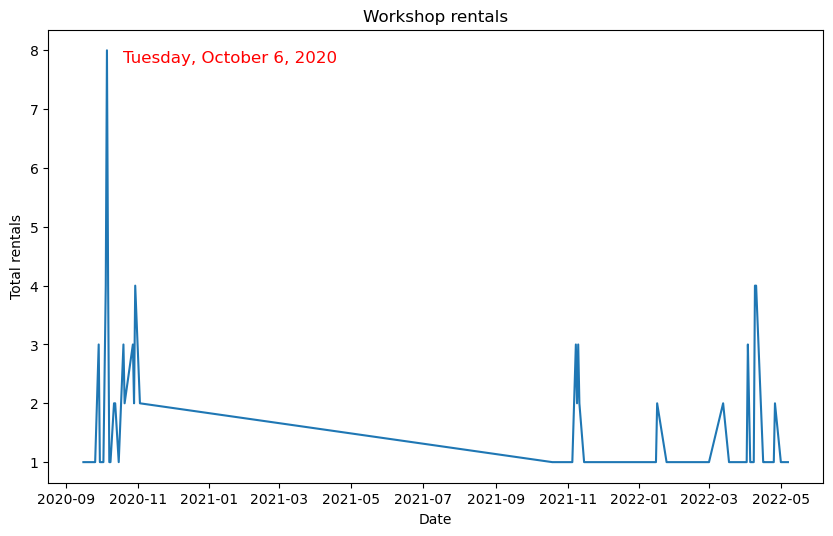

In [21]:
workshop_rentals_dt = workshop_df['lastrentalstart'].drop_duplicates()
workshop_rentals_dt = workshop_rentals_dt.groupby(workshop_rentals_dt.dt.date).count()
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(x=workshop_rentals_dt.index, y=workshop_rentals_dt.values, ax=ax, ci=None)
ax.set(xlabel='Date', ylabel='Total rentals', title='Workshop rentals')
ax.text(datetime(2020,10,20), 7.8, "Tuesday, October 6, 2020", fontsize=12, color='red')
plt.show()

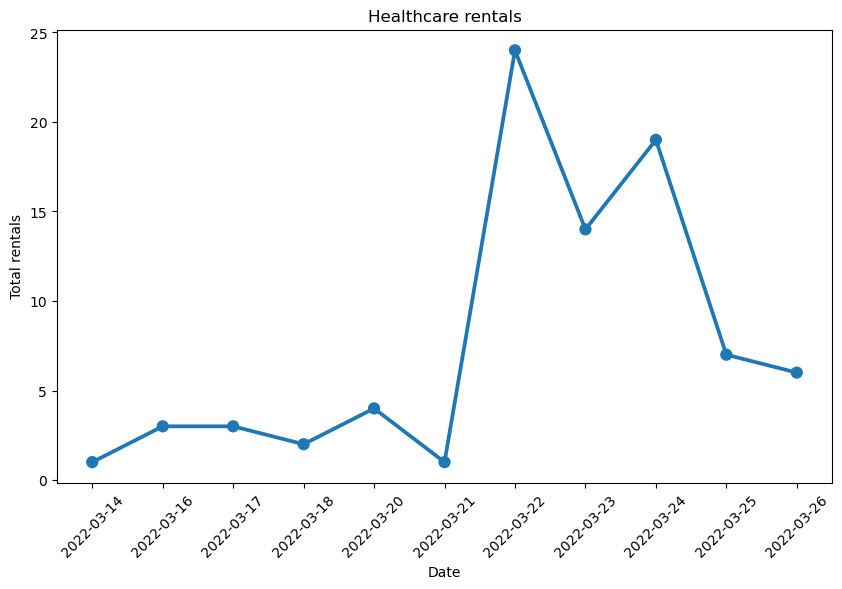

In [22]:
healthcare_df_dt = healthcare_df['lastrentalstart'].drop_duplicates()
healthcare_df_dt = healthcare_df_dt.groupby(healthcare_df_dt.dt.date).count()
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.pointplot(x=healthcare_df_dt.index, y=healthcare_df_dt.values, ax=ax, ci=None)
ax.set(xlabel='Date', ylabel='Total rentals', title='Healthcare rentals')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [23]:
workshop_df['bikeid'].value_counts()

117    8738
48     1917
50     1767
31     1633
23      712
94      533
52      532
95      352
58      195
Name: bikeid, dtype: int64

In [24]:
private_df['bikeid'].value_counts()

83    1918
Name: bikeid, dtype: int64

In [25]:
healthcare_df['bikeid'].value_counts()

48     343
9      219
42     219
74     219
85     219
118    211
12     206
6      198
102    197
109    193
69     159
26     156
86      39
Name: bikeid, dtype: int64

Moby has one bike with **ID 83** which seems to be *`Private`* and also different rental types called *`Workshop`* and *`Healthcare`*. Workshop is unknown if bikes were allocated either to an specific event or the workshop is provided by Moby Bikes in order to promote its services, for example. The same rule applies to Healthcare type.

In [26]:
general_hist_data = historical_data_clean[historical_data_clean['biketypename'] == 'DUB-General']

In [27]:
print(f'Private BIKE ID 83: {general_hist_data[general_hist_data["bikeid"] == 83].shape[0]} observations used on DUB-General')
print(f'Workshop BIKE ID 58: {general_hist_data[general_hist_data["bikeid"] == 58].shape[0]} observations used on DUB-General')
print(f'Healthcare BIKE ID 48: {general_hist_data[general_hist_data["bikeid"] == 48].shape[0]} observations used on DUB-General')

Private BIKE ID 83: 21476 observations used on DUB-General
Workshop BIKE ID 58: 19309 observations used on DUB-General
Healthcare BIKE ID 48: 21777 observations used on DUB-General


We can see that the same bike used as *`Private`*, *`Workshop`* and *`Healthcare`* are being used again from regular customers. Also, workshop day do not have a big impact overall as shown the maximum number of rentals was 8 on a Workshop day. 

Due to the fact that workshop day is unknown (in advance) and its volume on rentals is not significant high, it is not worthy to label a rental as workshop/healthcare (true/false). For the reasons discussed above, the data from those will be removed.

## Battery

In [28]:
battery_hist_df = general_hist_data.copy()
battery_hist_df.isnull().sum()

harvesttime            0
bikeid                 0
battery            64375
bikeidentifier         0
biketypename           0
ebikeprofileid         0
ebikestateid           0
isebike                0
ismotor                0
issmartlock            0
lastgpstime            0
lastrentalstart        0
latitude               0
longitude              0
spikeid                0
dtype: int64

In [29]:
battery_hist_df.loc[battery_hist_df['battery'] > 100]

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
5908,2021-04-03 13:00:02,103,268.0,102,DUB-General,1,2,True,False,False,2021-04-03 12:55:11,2021-04-03 12:40:00,53.3405,-6.2679,102


From the battery records there is a few cases that we can consider. Only one record has ` battery > 100` and a few negatives ones. To simplify the analysis the records will be normalized with values between `0 > x > 100`.

All missing values will not be transformed as it could be only malfunction issue when transmiting the data and it could mislead the analysis.

In [30]:
battery_hist_df.loc[battery_hist_df['battery'] > 100, 'battery'] = 100

In [31]:
negatives_b = battery_hist_df.loc[battery_hist_df['battery'] < 0]
negatives_b.shape[0]

34825

There are lots of negative/missing battery information as well as Latitude/Longitude. Because we are not using battery information for modeling, this feature won't be handled for now. All Latitude/Longitude with 0 will be replace as NaN.

When grouping the data all the historical info for these two features will be stored as lists.

In [32]:
# Transforming null values and negative battery values to -1
battery_hist_df['battery'].fillna(-1, inplace=True)
battery_hist_df.loc[battery_hist_df['battery'] < 0, 'battery'] = -1

In [33]:
negatives_b_n = battery_hist_df.loc[battery_hist_df['battery'] < 0]
print(f'Previous # of negative battery values: {negatives_b.shape[0]}')
print(f'# of negative values after transformation: {negatives_b_n.shape[0]}')
print(f'Difference: {negatives_b_n.shape[0]-negatives_b.shape[0]}')

Previous # of negative battery values: 34825
# of negative values after transformation: 99200
Difference: 64375


In [34]:
rentals = battery_hist_df.copy()
columns_to_drop = ['harvesttime','bikeidentifier','biketypename','ebikeprofileid',
                   'ebikestateid','isebike','ismotor','issmartlock','spikeid']
rentals.drop(columns_to_drop, axis=1, inplace=True)
rentals.shape

(1864028, 6)

### Grouping Rentals

In [35]:
def group_as_list(x):
    d = {'coordinates': x[['latitude','longitude']].values.tolist()}
    d['battery'] = list(x['battery']) # battery chronology, inverting it because it's in descending order
    d['lastgpstime'] = list(x['lastgpstime'])[0] # get the last gpstime (previously sorted)

    return pd.Series(d, index=['coordinates', 'battery', 'lastgpstime'])

# also sorting data by lastgpstime
grouped_rentals = rentals.sort_values("lastgpstime", ascending=False).groupby(['lastrentalstart', 'bikeid']).apply(group_as_list).reset_index()

In [36]:
grouped_rentals.tail()

,lastrentalstart,bikeid,coordinates,battery,lastgpstime
53659,2022-05-07 10:20:31,53,"[[53.3119, -6.2748], [0.0, 0.0]]","[90.0, 90.0]",2022-05-07 11:14:12
53660,2022-05-07 10:31:31,55,"[[53.3854, -6.25756], [53.3857, -6.25751]]","[57.0, 61.0]",2022-05-07 11:20:32
53661,2022-05-07 10:33:59,35,"[[53.3091, -6.21635], [53.3091, -6.21633]]","[80.0, 80.0]",2022-05-07 11:13:08
53662,2022-05-07 10:45:49,12,"[[53.3208, -6.2854], [0.0, 0.0]]","[92.0, 92.0]",2022-05-07 11:26:58
53663,2022-05-07 11:17:01,58,"[[0.0, 0.0]]",[43.0],2022-05-07 11:07:30


In [37]:
def get_valid_battery(battery_list):
    '''
    Iterate the battery list and return the first valid battery value. The battery list is in descending order.
    '''
    return next((item for item in reversed(battery_list) if item > 0), -1)

grouped_rentals['start_battery'] = grouped_rentals['battery'].apply(get_valid_battery) # get the first battery value

In [38]:
grouped_rentals.to_csv('../data/interim/rentals.csv', index=False)
grouped_rentals.shape

(53664, 6)

<a id="1.2"></a>
## Weather Data - Met Éireann

Regarding the weather data there are two important decisions to deal with.

- One is about from **which station** the **historical data will be collected**;
-  and the other one is about the **frequency of data**, which can be **hourly or daily**.

### Station Name: **PHOENIX PARK**

In [39]:
# Hourly data from Phoenix Park Station
phoenixpark_weather_hourly = pd.read_csv('../data/raw/hly175.csv', low_memory=False)
phoenixpark_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


Source: [https://data.gov.ie/dataset/phoenix-park-hourly-data](https://data.gov.ie/dataset/phoenix-park-hourly-data)

In [40]:
# Daily data from Phoenix Park Station
phoenixpark_weather_daily = pd.read_csv('../data/raw/dly175.csv')
phoenixpark_weather_daily.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,soil
0,16-aug-2003,0,20.1,0,7.5,4,,0,0.0,1013.7,18.565
1,17-aug-2003,0,21.3,0,11.6,0,7.5,0,1.1,1007.5,18.280
2,18-aug-2003,0,20.3,0,8.5,0,4.3,0,0.0,1008.8,17.825
3,19-aug-2003,0,19.9,0,11.3,0,7.7,0,0.0,1014.3,18.138
4,20-aug-2003,0,21.5,0,10.8,0,6.9,0,0.0,1013.6,18.432


Source: [https://data.gov.ie/dataset/phoenixpark-daily-data](https://data.gov.ie/dataset/phoenixpark-daily-data)

### Station Name: **DUBLIN AIRPORT**

In [41]:
# Hourly data from Dublin Airport Station
dublin_airport_weather_hourly = pd.read_csv('../data/raw/hly532.csv', low_memory=False, parse_dates=['date'])
dublin_airport_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,1992-01-01 00:00:00,0,0.0,0,8.4,0,6.6,4.3,8.3,75,...,2,23,2,210,2,11,0.0,25000,999,3
1,1992-01-01 01:00:00,0,0.0,0,8.6,0,6.6,4.0,8.1,73,...,2,23,2,220,2,11,0.0,25000,100,6
2,1992-01-01 02:00:00,0,0.0,0,9.0,0,7.0,4.5,8.4,73,...,2,22,2,220,2,11,0.0,25000,100,6
3,1992-01-01 03:00:00,0,0.0,0,9.5,0,7.4,4.8,8.6,73,...,2,22,2,220,2,11,0.0,25000,25,6
4,1992-01-01 04:00:00,0,0.0,0,9.5,0,7.4,4.8,8.6,73,...,2,23,2,230,2,11,0.0,25000,25,6


In [42]:
print(f'Total number of rows: {dublin_airport_weather_hourly.shape[0]}')

Total number of rows: 265873


Source: [https://data.gov.ie/dataset/dublin-airport-hourly-data](https://data.gov.ie/dataset/dublin-airport-hourly-data)

### Phoenix Park Station vs Dublin Aiport Station
Geographically, the station at Phoenix Park would be the most suitable choice but unfortunately, they do not collect Wind information which in Ireland plays an important role when deciding to go cycling or not. For those who are not familiar with Irish weather, it rains a lot and mostly we do not have much choice about it but the wind is something that can prevent you go outside or choosing a different kind of transportation. Heavy rain is not that common, though.

### Hourly vs Daily data
A daily data to the business could make more sense but because the weather is so unpredictable in Ireland (it can completely change in an hour), the best option would be hourly data if looking at a historical perspective. Important to note that from the Weather API the forecast is provided hourly. For simplicity and better planning, we can always aggregate the predicted results by day.

In [43]:
dublin_airport_weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265873 entries, 0 to 265872
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    265873 non-null  datetime64[ns]
 1   ind     265873 non-null  int64         
 2   rain    265873 non-null  float64       
 3   ind.1   265873 non-null  int64         
 4   temp    265873 non-null  float64       
 5   ind.2   265873 non-null  int64         
 6   wetb    265873 non-null  float64       
 7   dewpt   265873 non-null  float64       
 8   vappr   265873 non-null  object        
 9   rhum    265873 non-null  object        
 10  msl     265873 non-null  float64       
 11  ind.3   265873 non-null  int64         
 12  wdsp    265873 non-null  int64         
 13  ind.4   265873 non-null  int64         
 14  wddir   265873 non-null  object        
 15  ww      265873 non-null  int64         
 16  w       265873 non-null  int64         
 17  sun     265873 non-null  floa

In [44]:
dublin_airport_weather_hourly.tail()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
265868,2022-04-30 20:00:00,0,1.2,0,10.7,0,10.1,9.6,11.9,92,...,2,5,2,230,61,66,0.0,8000,14,8
265869,2022-04-30 21:00:00,0,0.3,0,10.2,0,9.7,9.2,11.6,93,...,2,6,2,230,61,66,0.0,8000,32,7
265870,2022-04-30 22:00:00,0,0.2,0,9.8,0,9.5,9.1,11.6,96,...,2,7,2,240,60,62,0.0,8000,35,7
265871,2022-04-30 23:00:00,0,0.5,0,9.8,0,9.5,9.1,11.6,96,...,2,7,2,230,60,62,0.0,8000,35,7
265872,2022-05-01 00:00:00,2,0.0,0,10.0,0,9.5,8.9,11.5,93,...,2,8,2,230,60,62,0.0,9000,42,7


In [45]:
recent_dubairport_data = dublin_airport_weather_hourly.copy()
columns_to_drop = ['ind','ind.1','ind.2','ind.3','vappr','msl','ind.4','wddir','ww','w','sun','vis','clht','clamt','wetb','dewpt']
weather_data = recent_dubairport_data.drop(columns=columns_to_drop)
weather_data.isnull().sum()

date    0
rain    0
temp    0
rhum    0
wdsp    0
dtype: int64

In [46]:
weather_data.to_csv('../data/interim/hist_weather_data.csv', index=False)
weather_data.tail()

,date,rain,temp,rhum,wdsp
265868,2022-04-30 20:00:00,1.2,10.7,92,5
265869,2022-04-30 21:00:00,0.3,10.2,93,6
265870,2022-04-30 22:00:00,0.2,9.8,96,7
265871,2022-04-30 23:00:00,0.5,9.8,96,7
265872,2022-05-01 00:00:00,0.0,10.0,93,8


In [47]:
weather_data['dt'] = pd.to_datetime(weather_data['date'].dt.date)
weather_data['hour'] = weather_data['date'].dt.hour
weather_data['day'] = weather_data['date'].dt.day
weather_data['month'] = weather_data['date'].dt.month
weather_data['year'] = weather_data['date'].dt.year
weather_data.drop(columns='date', axis=1, inplace=True)
weather_data.rename(columns={'dt':'date'},inplace=True)

## Combining Rentals and Weather data

In [48]:
grouped_rentals.shape, weather_data.shape

((53664, 6), (265873, 9))

In [49]:
rentals = grouped_rentals.copy()
weather = weather_data.copy()
rentals['date'] = pd.to_datetime(rentals['lastrentalstart'].dt.date)
rentals['hour'] = rentals['lastrentalstart'].dt.hour

In [50]:
all_data = pd.merge(rentals, weather, on=['date', 'hour'])
all_data.to_csv('../data/interim/all_data.csv', index=False)

## Grouping data to reflect hourly count of rentals

In [51]:
hourly_rentals = rentals.groupby(['date', 'hour']).size().reset_index(name='count')
hourly_rentals.tail(3)

,date,hour,count
11275,2022-05-07,9,6
11276,2022-05-07,10,10
11277,2022-05-07,11,1


### Dataframe including only hours with *at least* 1 rental

In [52]:
hourly_data = pd.merge(hourly_rentals, weather, on=['date','hour'])
hourly_data.to_csv('../data/interim/hourly_rentals.csv', index=False)
hourly_data.tail(3)

,date,hour,count,rain,temp,rhum,wdsp,day,month,year
11142,2022-04-30,22,1,0.2,9.8,96,7,30,4,2022
11143,2022-04-30,23,1,0.5,9.8,96,7,30,4,2022
11144,2022-05-01,0,3,0.0,10.0,93,8,1,5,2022


### Dataframe with all hours (including none rental)

In [53]:
hourly_data_withzeros = pd.merge(weather, hourly_rentals, on=['date','hour'], how='left')
hourly_data_withzeros['count'] = hourly_data_withzeros['count'].fillna(0).astype(int)
hourly_data_withzeros.to_csv('../data/interim/hourly_data.csv', index=False)
hourly_data_withzeros.tail(3)

,rain,temp,rhum,wdsp,date,hour,day,month,year,count
265870,0.2,9.8,96,7,2022-04-30,22,30,4,2022,1
265871,0.5,9.8,96,7,2022-04-30,23,30,4,2022,1
265872,0.0,10.0,93,8,2022-05-01,0,1,5,2022,3


### Sampling

In [54]:
start_train_dt, end_train_dt = datetime(2021, 3, 1), datetime(2022, 2, 28) # train sample
start_test_dt, end_test_dt = datetime(2022, 3, 1), datetime(2022, 4, 30) # test sample

In [55]:
df_train = hourly_data_withzeros[(hourly_data_withzeros['date'] >= start_train_dt) & (hourly_data_withzeros['date'] <= end_train_dt)]
df_test = hourly_data_withzeros[(hourly_data_withzeros['date'] >= start_test_dt) & (hourly_data_withzeros['date'] <= end_test_dt)]

In [56]:
df_train.to_csv('../data/interim/dfsample_train.csv', index=False)
df_test.to_csv('../data/interim/dfsample_test.csv', index=False)

In [57]:
df_train.shape, df_test.shape

((8760, 10), (1464, 10))

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini